In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# Load a dataset into a Pandas Dataframe
dataset_df = pd.read_csv('train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (8693, 14)


In [5]:
# Display the first 5 examples
dataset_df.head(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


There are 12 feature columns. Using these features your model has to predict whether the passenger is rescued or not indicated by the column `Transported`.

# Let explore the databse 

In [6]:
dataset_df.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Plotting Bar chart for column: Transported

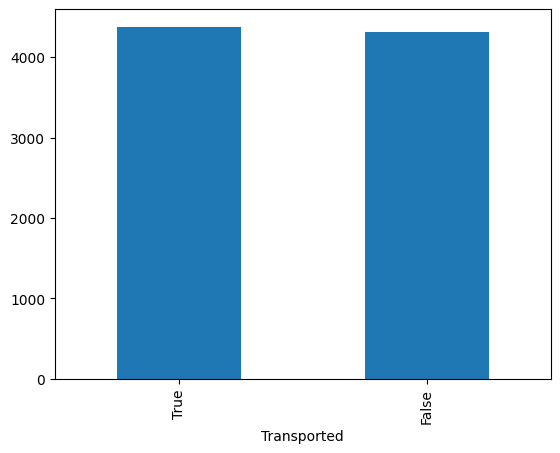

In [8]:
plot_df = dataset_df.Transported.value_counts()
plot_df.plot(kind="bar")
plt.show()

Plotting the age distribution of passengers 

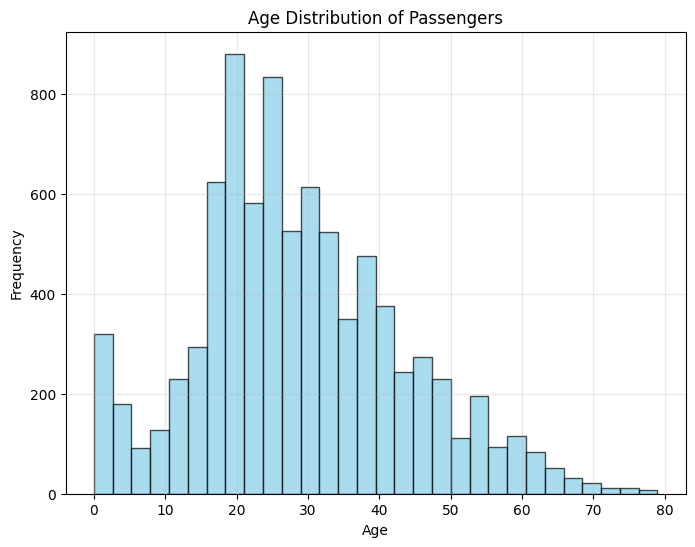

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(dataset_df['Age'].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Age Distribution of Passengers')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

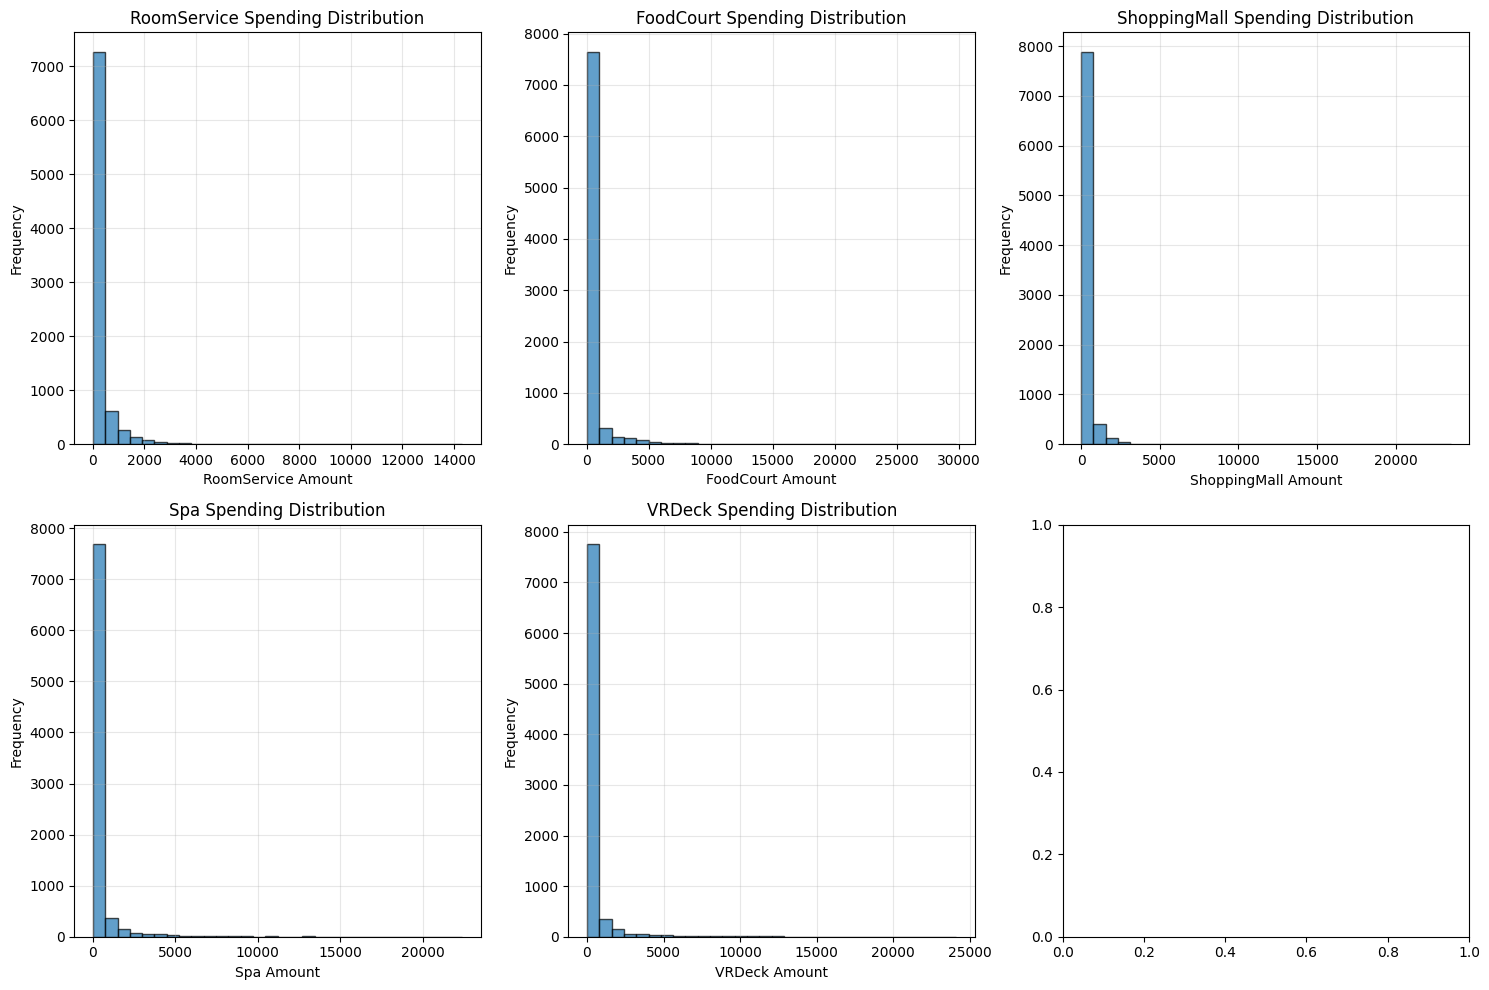

In [10]:
# Plotting spendings accros various areas of the spaceship
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(spending_cols):
    axes[i].hist(dataset_df[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{col} Spending Distribution')
    axes[i].set_xlabel(f'{col} Amount')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

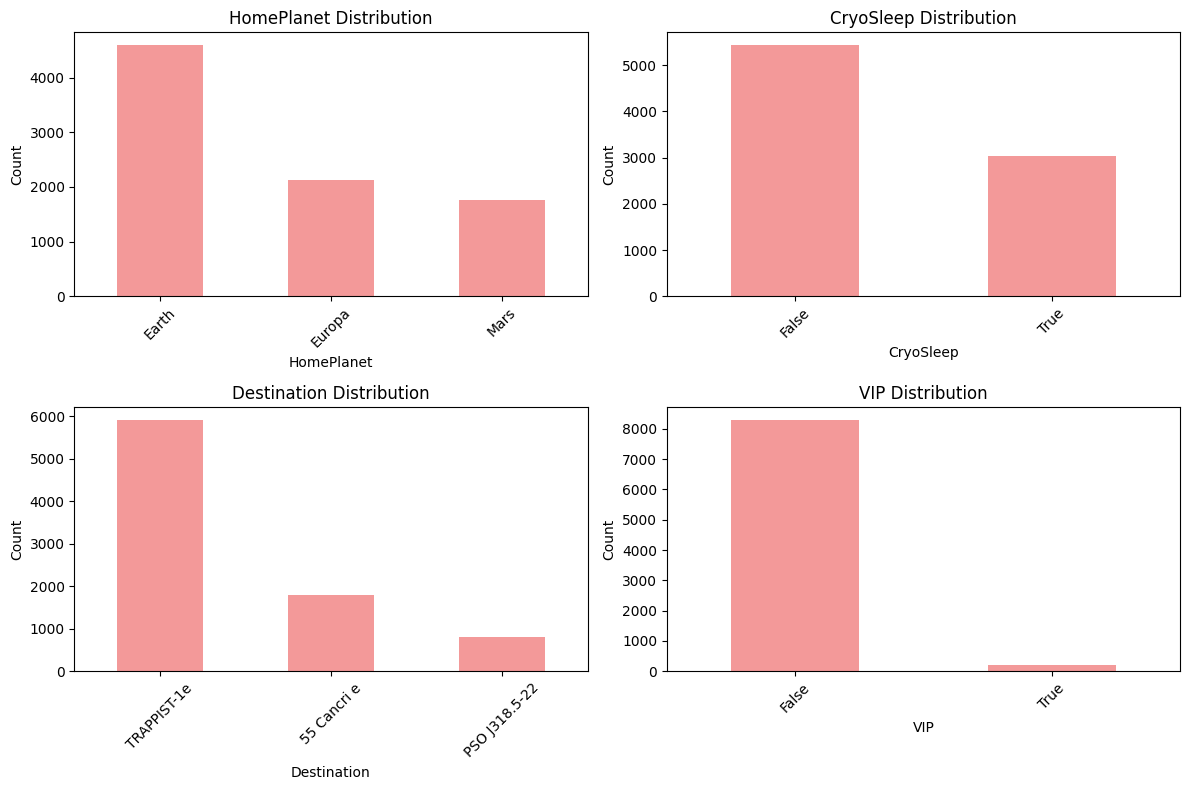

In [12]:
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    dataset_df[col].value_counts().plot(kind='bar', ax=axes[i], color='lightcoral', alpha=0.8)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

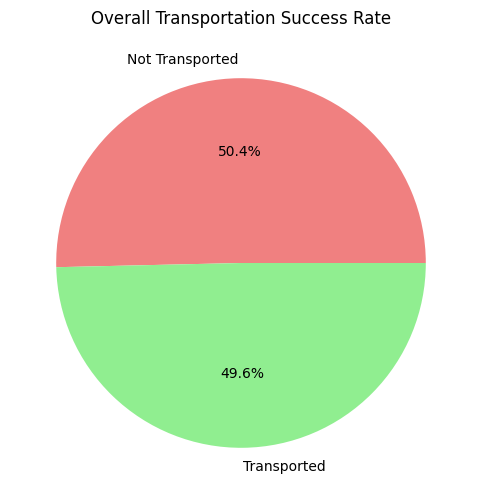

In [13]:
#Checking the transported and not-transported varation
plt.figure(figsize=(8, 6))
transport_counts = dataset_df['Transported'].value_counts()
plt.pie(transport_counts.values, labels=['Not Transported', 'Transported'], 
        autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Overall Transportation Success Rate')
plt.show()

<Figure size 800x600 with 0 Axes>

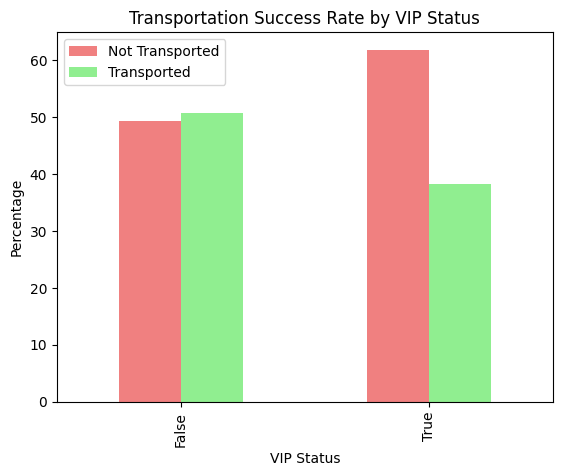

In [14]:
#Checking if being a VIP was better or not.
plt.figure(figsize=(8, 6))
vip_transport = pd.crosstab(dataset_df['VIP'], dataset_df['Transported'], normalize='index') * 100
vip_transport.plot(kind='bar', color=['lightcoral', 'lightgreen'])
plt.title('Transportation Success Rate by VIP Status')
plt.xlabel('VIP Status')
plt.ylabel('Percentage')
plt.legend(['Not Transported', 'Transported'])
plt.show()

slightly more not transported in the vip section

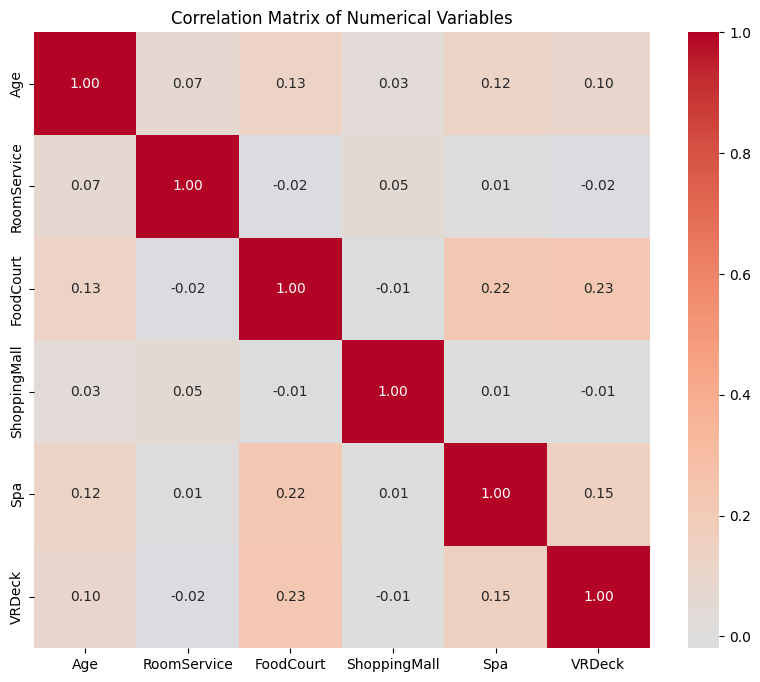

In [15]:
#Looking for corelation between spending areas.
plt.figure(figsize=(10, 8))
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
correlation_matrix = dataset_df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

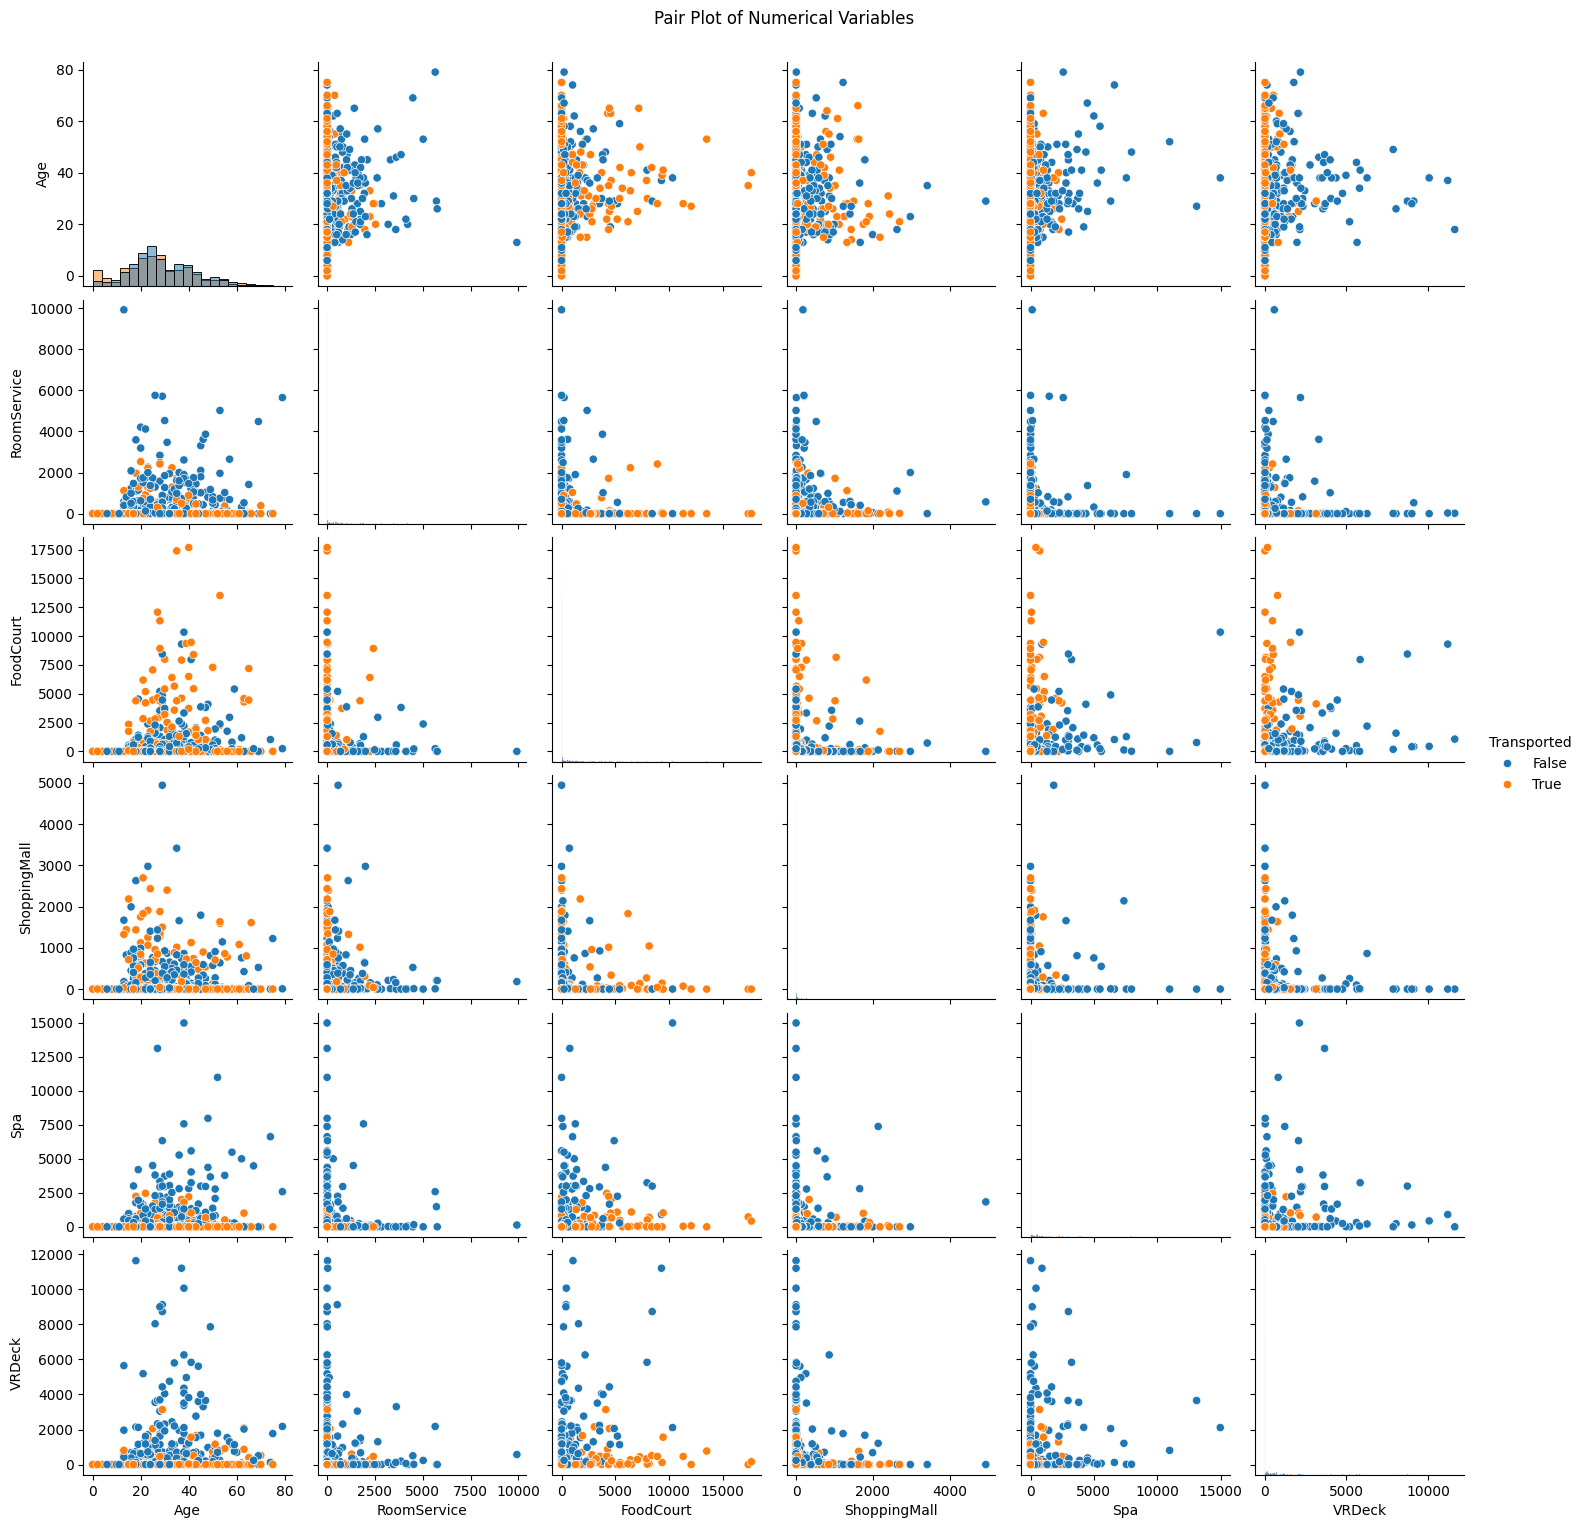

In [16]:
#Exploring all possible relationships between numerical variables, colored by transportation status.
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
# Sample data if dataset is large (for performance)
sample_df = dataset_df[numerical_cols + ['Transported']].sample(n=min(1000, len(dataset_df)))
sns.pairplot(sample_df, hue='Transported', diag_kind='hist')
plt.suptitle('Pair Plot of Numerical Variables', y=1.02)
plt.show()

Looking at the spending variables, you can see a clear pattern:
    -Orange dots (Transported=True) cluster heavily at zero spending across ALL services
    -Blue dots (Transported=False) show varied spending patterns

This indecates that the passengers in CryoSleep probably don't spend money (they're sleeping!) and have higher transportation success rates.

In [17]:
pd.crosstab(dataset_df['CryoSleep'], dataset_df['Transported'], normalize='index')

Transported,False,True
CryoSleep,,
False,0.671079,0.328921
True,0.182417,0.817583


CryoSleep = True (Sleeping passengers):

81.76% get transported successfully
Only 18.24% fail to be transported

CryoSleep = False (Awake passengers):

Only 32.89% get transported successfully
67.11% fail to be transported

This indecates that passengers in CryoSleep are 2.5x more likely to be transported.

# Prepare the dataset

creating a function for cleaning the dataset based business logic and data patterns

In [18]:
def handle_missing_values(df):
    df_clean = df.copy()
    
    # Age: Fill with median (robust to outliers)
    df_clean['Age'].fillna(df_clean['Age'].median(), inplace=True)
    
    # CryoSleep: Fill with False (conservative assumption - assume awake)
    df_clean['CryoSleep'].fillna(False, inplace=True)
    
    
    # VIP: Fill with False (most passengers are not VIP)
    df_clean['VIP'].fillna(False, inplace=True)
    
    
    categorical_cols = ['HomePlanet', 'Destination']
    for col in categorical_cols:
        df_clean[col].fillna('Unknown', inplace=True)
        print(f"{col} missing values filled with 'Unknown'")
    
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in spending_cols:
        df_clean[col].fillna(0, inplace=True)
    
    return df_clean

# Apply missing value handling
df_clean = handle_missing_values(dataset_df)
df_clean

HomePlanet missing values filled with 'Unknown'
Destination missing values filled with 'Unknown'


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# FEATURE ENGINEERING 

Createing features based on spending patterns from our EDA insights

In [19]:
def create_spending_features(df):
    df_features = df.copy()
    
    # Total spending 
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df_features['total_spending'] = df_features[spending_cols].sum(axis=1)
    
    # Binary spending indicator 
    df_features['has_spending'] = (df_features['total_spending'] > 0).astype(int)
    
    # Spending categories(None,Low,Medium,High)
    df_features['spending_level'] = pd.cut(df_features['total_spending'], 
                                         bins=[0, 1, 100, 1000, float('inf')], 
                                         labels=['None', 'Low', 'Medium', 'High'])
    
    # Entertainment spending 
    df_features['entertainment_spending'] = (df_features['FoodCourt'] + df_features['Spa'] + df_features['VRDeck'])
    
    # Service type preference 
    df_features['prefers_room_service'] = (df_features['RoomService'] > df_features['entertainment_spending']).astype(int)
    
    return df_features

df_features = create_spending_features(df_clean)
print(df_features.head(10))

  PassengerId HomePlanet  CryoSleep  Cabin    Destination   Age    VIP  \
0     0001_01     Europa      False  B/0/P    TRAPPIST-1e  39.0  False   
1     0002_01      Earth      False  F/0/S    TRAPPIST-1e  24.0  False   
2     0003_01     Europa      False  A/0/S    TRAPPIST-1e  58.0   True   
3     0003_02     Europa      False  A/0/S    TRAPPIST-1e  33.0  False   
4     0004_01      Earth      False  F/1/S    TRAPPIST-1e  16.0  False   
5     0005_01      Earth      False  F/0/P  PSO J318.5-22  44.0  False   
6     0006_01      Earth      False  F/2/S    TRAPPIST-1e  26.0  False   
7     0006_02      Earth       True  G/0/S    TRAPPIST-1e  28.0  False   
8     0007_01      Earth      False  F/3/S    TRAPPIST-1e  35.0  False   
9     0008_01     Europa       True  B/1/P    55 Cancri e  14.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck                Name  \
0          0.0        0.0           0.0     0.0     0.0     Maham Ofracculy   
1        109.0        9.0  

Createing features based on age and demographic patterns
Note: During EDA i realized that i would be bettet to create catogary of age rather than a continous state.

In [20]:
def create_demographic_features(df):
    df_demo = df.copy()
    
    # Age groups (based on pair plot insights)
    df_demo['age_group'] = pd.cut(df_demo['Age'], 
                                bins=[0, 18, 30, 50, 100], 
                                labels=['Child', 'Young_Adult', 'Adult', 'Senior'])
    
    # Age-spending interaction (older people spend more on certain services)
    df_demo['age_spending_ratio'] = df_demo['Age'] / (df_demo['total_spending'] + 1)
    
    
    return df_demo

df_demo = create_demographic_features(df_features)
print(df_demo.head(10))

  PassengerId HomePlanet  CryoSleep  Cabin    Destination   Age    VIP  \
0     0001_01     Europa      False  B/0/P    TRAPPIST-1e  39.0  False   
1     0002_01      Earth      False  F/0/S    TRAPPIST-1e  24.0  False   
2     0003_01     Europa      False  A/0/S    TRAPPIST-1e  58.0   True   
3     0003_02     Europa      False  A/0/S    TRAPPIST-1e  33.0  False   
4     0004_01      Earth      False  F/1/S    TRAPPIST-1e  16.0  False   
5     0005_01      Earth      False  F/0/P  PSO J318.5-22  44.0  False   
6     0006_01      Earth      False  F/2/S    TRAPPIST-1e  26.0  False   
7     0006_02      Earth       True  G/0/S    TRAPPIST-1e  28.0  False   
8     0007_01      Earth      False  F/3/S    TRAPPIST-1e  35.0  False   
9     0008_01     Europa       True  B/1/P    55 Cancri e  14.0  False   

   RoomService  FoodCourt  ShoppingMall  ...  VRDeck                Name  \
0          0.0        0.0           0.0  ...     0.0     Maham Ofracculy   
1        109.0        9.0        

Now our MVF(Most Vlauable Feature). Creating features related to cryosleep.

In [22]:
def create_cryosleep_features(df):
    df_cryo = df.copy()
    
    # CryoSleep + Spending interaction(should be 0)
    df_cryo['cryo_spending_anomaly'] = ((df_cryo['CryoSleep'] == True) & 
                                       (df_cryo['total_spending'] > 0)).astype(int)
    
    # CryoSleep + VIP interaction
    df_cryo['cryo_vip_combo'] = df_cryo['CryoSleep'].astype(int) * df_cryo['VIP'].astype(int)
    
    # Expected vs actual spending 
    df_cryo['expected_spending'] = np.where(df_cryo['CryoSleep'] == True, 0, 
                                          df_cryo['total_spending'])
    
    
    print(f"CryoSleep spending anomalies: {df_cryo['cryo_spending_anomaly'].sum()}")
    print(f"CryoSleep + VIP combinations: {df_cryo['cryo_vip_combo'].sum()}")
    
    return df_cryo
df_engineered = create_cryosleep_features(df_demo)
print(df_engineered.head(10))


CryoSleep spending anomalies: 0
CryoSleep + VIP combinations: 21
  PassengerId HomePlanet  CryoSleep  Cabin    Destination   Age    VIP  \
0     0001_01     Europa      False  B/0/P    TRAPPIST-1e  39.0  False   
1     0002_01      Earth      False  F/0/S    TRAPPIST-1e  24.0  False   
2     0003_01     Europa      False  A/0/S    TRAPPIST-1e  58.0   True   
3     0003_02     Europa      False  A/0/S    TRAPPIST-1e  33.0  False   
4     0004_01      Earth      False  F/1/S    TRAPPIST-1e  16.0  False   
5     0005_01      Earth      False  F/0/P  PSO J318.5-22  44.0  False   
6     0006_01      Earth      False  F/2/S    TRAPPIST-1e  26.0  False   
7     0006_02      Earth       True  G/0/S    TRAPPIST-1e  28.0  False   
8     0007_01      Earth      False  F/3/S    TRAPPIST-1e  35.0  False   
9     0008_01     Europa       True  B/1/P    55 Cancri e  14.0  False   

   RoomService  FoodCourt  ShoppingMall  ...  total_spending  has_spending  \
0          0.0        0.0           0.0  .

Encodeing categorical variables for XGBoost (handles label encoding well)

In [23]:
def encode_categorical_variables(df):
    df_encoded = df.copy()
    encoders = {}
    
    # Categorical columns to encode
    categorical_cols = ['HomePlanet', 'Destination', 'spending_level','age_group']
    
    for col in categorical_cols:
        if col in df_encoded.columns:
            le = LabelEncoder()
            df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
            encoders[col] = le
    
    # Boolean columns to integer
    boolean_cols = ['CryoSleep', 'VIP']
    for col in boolean_cols:
        df_encoded[col] = df_encoded[col].astype(int)
    
    return df_encoded, encoders
# saving encoders to use during testing 
df_encoded, label_encoders = encode_categorical_variables(df_engineered)
print(df_encoded.head(10),label_encoders)

  PassengerId  HomePlanet  CryoSleep  Cabin  Destination   Age  VIP  \
0     0001_01           1          0  B/0/P            2  39.0    0   
1     0002_01           0          0  F/0/S            2  24.0    0   
2     0003_01           1          0  A/0/S            2  58.0    1   
3     0003_02           1          0  A/0/S            2  33.0    0   
4     0004_01           0          0  F/1/S            2  16.0    0   
5     0005_01           0          0  F/0/P            1  44.0    0   
6     0006_01           0          0  F/2/S            2  26.0    0   
7     0006_02           0          1  G/0/S            2  28.0    0   
8     0007_01           0          0  F/3/S            2  35.0    0   
9     0008_01           1          1  B/1/P            0  14.0    0   

   RoomService  FoodCourt  ShoppingMall  ...  total_spending  has_spending  \
0          0.0        0.0           0.0  ...             0.0             0   
1        109.0        9.0          25.0  ...           736.0  

Selecting the most relevant features for XGBoost training

In [24]:
def select_features_for_model(df):
    # Core features 
    core_features = [
        'CryoSleep',  # Our key insight
        'Age', 'VIP', 'HomePlanet', 'Destination'
    ]
    
    # Spending features
    spending_features = [
        'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
        'total_spending', 'has_spending', 'entertainment_spending'
    ]
    
    # Engineered features
    engineered_features = [
        'age_group', 'spending_level', 'prefers_room_service',
        'cryo_spending_anomaly', 'age_spending_ratio'
    ]
    
    # Combine features
    selected_features = core_features + spending_features + engineered_features
    
    final_features = [f for f in selected_features if f in df.columns]
    
    print(f"=== SELECTED FEATURES FOR MODEL ({len(final_features)}) ===")
    for i, feature in enumerate(final_features, 1):
        print(f"{i:2d}. {feature}")
    
    return final_features


feature_columns = select_features_for_model(df_encoded)
print(feature_columns)

=== SELECTED FEATURES FOR MODEL (18) ===
 1. CryoSleep
 2. Age
 3. VIP
 4. HomePlanet
 5. Destination
 6. RoomService
 7. FoodCourt
 8. ShoppingMall
 9. Spa
10. VRDeck
11. total_spending
12. has_spending
13. entertainment_spending
14. age_group
15. spending_level
16. prefers_room_service
17. cryo_spending_anomaly
18. age_spending_ratio
['CryoSleep', 'Age', 'VIP', 'HomePlanet', 'Destination', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_spending', 'has_spending', 'entertainment_spending', 'age_group', 'spending_level', 'prefers_room_service', 'cryo_spending_anomaly', 'age_spending_ratio']


In [25]:
X = df_encoded[feature_columns]
y = df_encoded['Transported']

print(f"\nFinal dataset shape: {X.shape},{y.shape}")
print(f"Target distribution: {y.value_counts(normalize=True).to_dict()}")


Final dataset shape: (8693, 18),(8693,)
Target distribution: {True: 0.5036236051995858, False: 0.4963763948004141}


# Train a Random Forest model using XGBoost.

Test-Train split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape},{y_train.shape}")
print(f"Test set size: {X_test.shape},{y_test.shape}")
print(f"Training set target distribution: {y_train.value_counts(normalize=True).to_dict()}")


Training set size: (6954, 18),(6954,)
Test set size: (1739, 18),(1739,)
Training set target distribution: {True: 0.5035950532067874, False: 0.49640494679321256}


In [73]:
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["error", "logloss"],
    use_label_encoder=False,
    random_state=42,
    n_estimators=600,
    max_depth=6,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,
    reg_lambda=1
)


print("Training XGBoost model...")
eval_set = [(X_train, y_train), (X_test, y_test)]

xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set, 
    verbose=False
)

evals_result = xgb_model.evals_result()

Training XGBoost model...


In [ ]:
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Accuracy
train_accuracy = xgb_model.score(X_train, y_train)
test_accuracy = xgb_model.score(X_test, y_test)

print(" MODEL PERFORMANCE ")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Overfitting Gap: {train_accuracy - test_accuracy:.4f}")

# Detailed classification report
print("\n DETAILED CLASSIFICATION REPORT ")
print(classification_report(y_test, y_pred))

# Cross-validation
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')
print(f"\n CROSS-VALIDATION RESULTS ")
print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

=== MODEL PERFORMANCE ===
Training Accuracy: 0.8315
Test Accuracy: 0.7999
Overfitting Gap: 0.0316

=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

       False       0.81      0.78      0.79       863
        True       0.79      0.82      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


=== CROSS-VALIDATION RESULTS ===
CV Accuracy: 0.7993 (+/- 0.0150)


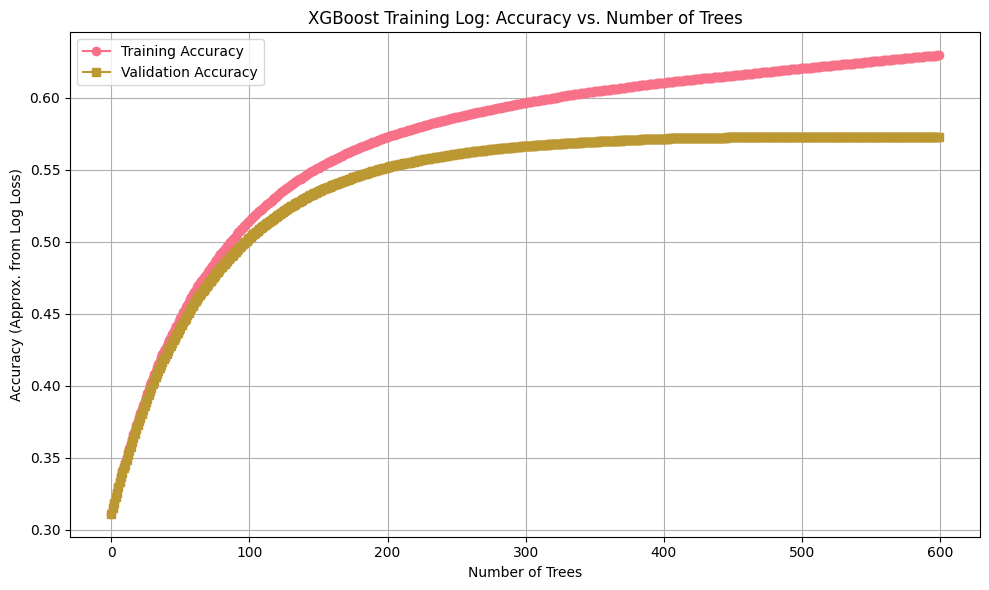

In [ ]:
train_metric = evals_result['validation_0']['logloss']
val_metric = evals_result['validation_1']['logloss']

plt.figure(figsize=(10, 6))
plt.plot([1 - x for x in train_metric], label='Training Accuracy', marker='o')
plt.plot([1 - x for x in val_metric], label='Validation Accuracy', marker='s')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy (Approx. from Log Loss)')
plt.title('XGBoost Training Log: Accuracy vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


=== TOP 10 MOST IMPORTANT FEATURES ===
                 feature  importance
11          has_spending    0.528864
14        spending_level    0.335452
3             HomePlanet    0.020554
0              CryoSleep    0.018822
15  prefers_room_service    0.013489
6              FoodCourt    0.012947
7           ShoppingMall    0.010820
8                    Spa    0.009966
10        total_spending    0.009852
9                 VRDeck    0.008819


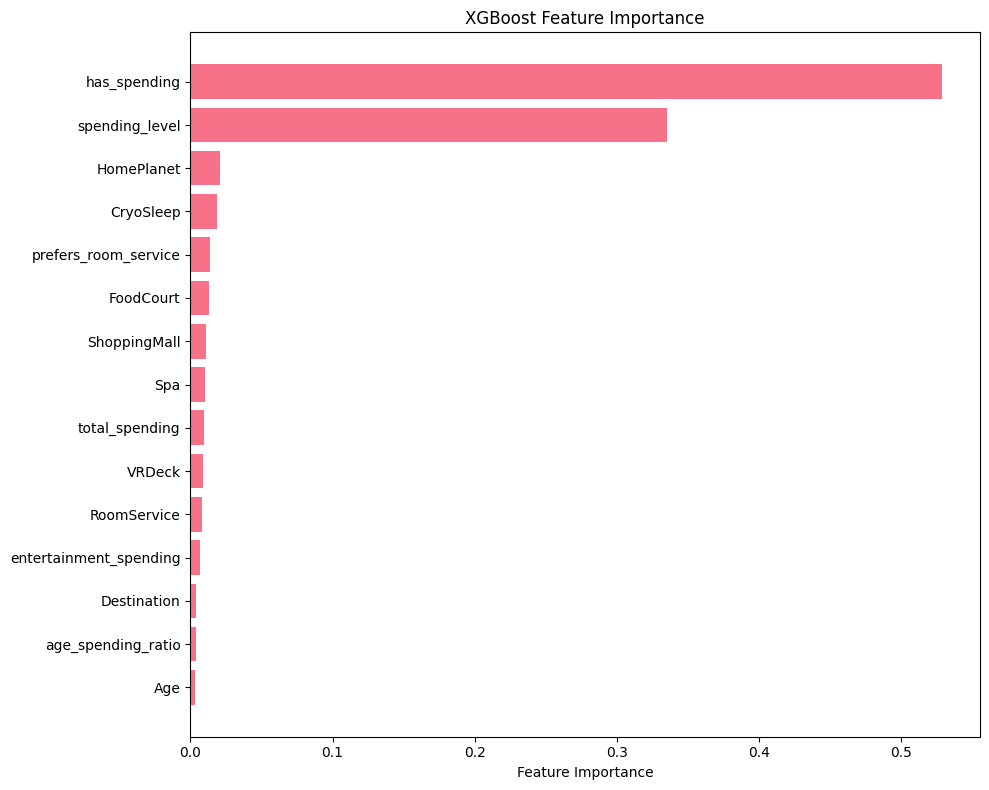

In [63]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("=== TOP 10 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The model ranked has_spending and spending_level as the top features. This aligns with our hypothesis: CryoSleep passengers don’t spend, so the absence of spending is a strong indirect signal of being in CryoSleep.

Even though CryoSleep itself ranks lower, its effect is already captured through has_spending, making the model behavior consistent with our expectations.`

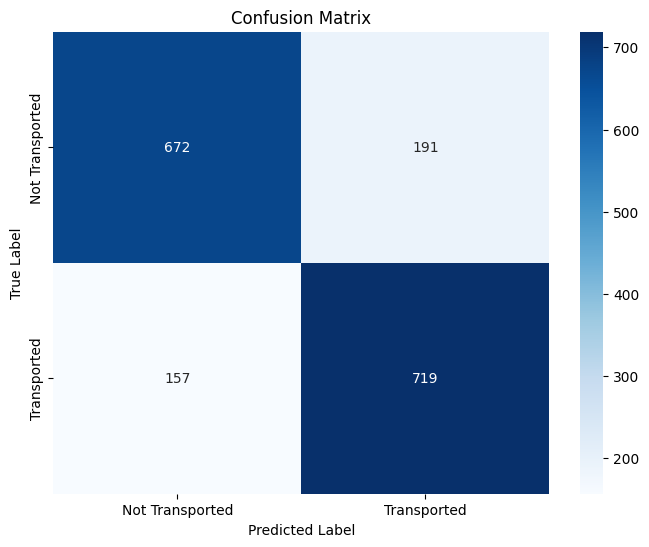

In [64]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Transported', 'Transported'],
            yticklabels=['Not Transported', 'Transported'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

The confusion matrix shows that the model is balenced and performs well on both classes.

In [66]:
df_test = pd.read_csv('test.csv')
print(df_test.head())
df_submission=pd.read_csv('sample_submission.csv')
print(df_submission.head())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRAPPIST-1e  19.0  False   
2     0019_01     Europa      True  C/0/S  55 Cancri e  31.0  False   
3     0021_01     Europa     False  C/1/S  TRAPPIST-1e  38.0  False   
4     0023_01      Earth     False  F/5/S  TRAPPIST-1e  20.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck              Name  
0          0.0        0.0           0.0     0.0     0.0   Nelly Carsoning  
1          0.0        9.0           0.0  2823.0     0.0    Lerome Peckers  
2          0.0        0.0           0.0     0.0     0.0   Sabih Unhearfus  
3          0.0     6652.0           0.0   181.0   585.0  Meratz Caltilter  
4         10.0        0.0         635.0     0.0     0.0   Brence Harperez  
  PassengerId  Transported
0     0013_01        False
1     0018_01        False
2     0019_01        False
3     002

In [ ]:
# Cell: Predict Transported for Test Set and Generate Submission

# Load test data
df_test = pd.read_csv('test.csv')

# Apply preprocessing pipeline (same as training)
df_test_clean = handle_missing_values(df_test)
df_test_features = create_spending_features(df_test_clean)
df_test_demo = create_demographic_features(df_test_features)
df_test_engineered = create_cryosleep_features(df_test_demo)
df_test_encoded, _ = encode_categorical_variables(df_test_engineered) 

# Select features used during training
X_test_final = df_test_encoded[feature_columns]

# Predict Transported
test_predictions = xgb_model.predict(X_test_final)

# Convert to boolean 
df_submission = pd.DataFrame({
    'PassengerId': df_test_encoded['PassengerId'],
    'Transported': test_predictions.astype(bool)
})

df_submission.to_csv('submission.csv', index=False)
print("✅ submission.csv created successfully!")


HomePlanet missing values filled with 'Unknown'
Destination missing values filled with 'Unknown'
CryoSleep spending anomalies: 0
CryoSleep + VIP combinations: 7
✅ submission.csv created successfully!


In [69]:
df_submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
